# Trader Performance & Market Sentiment Analysis

**Objective:** Merge Hyperliquid trader records with Bitcoin's Fear & Greed Index to uncover how market emotions influence trading outcomes. This end-to-end analysis covers data ingestion, preprocessing, statistical summaries, and visualizations, concluding with actionable insights.

### Datasets
- `historical_data.csv`: Trade-level records (Account, Coin, Side, Size USD, Fee, Closed PnL, Timestamp IST, etc.).
- `fear_greed_index.csv`: Daily Fear & Greed Index with `classification` labels (e.g., Extreme Fear, Fear, Neutral, Greed, Extreme Greed).

### What I'll do
- Load and sanity-check both datasets (shape, sample, missing values).
- Harmonize dates and merge trades with daily sentiment classifications.
- Summarize performance by sentiment (PnL, size, fees, trade counts).
- Explore intraday effects, distributions, top symbols, correlations, and trends.
- Synthesize findings into concrete strategy recommendations.



## 1. Setup & Data Acquisition
We  use `gdown` to download datasets from Google Drive for reproducibility.

Environment assumptions:
- Python 3.9+
- Packages: pandas, matplotlib, numpy (installed below if missing)

In [ ]:
import gdown

# Download datasets (CSV format)
gdown.download('https://drive.google.com/uc?export=download&id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs', output='historical_data.csv', quiet=True)
gdown.download('https://drive.google.com/uc?export=download&id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf', output='fear_greed_index.csv', quiet=True)

'fear_greed_index.csv'

## 2. Data Loading & Initial Inspection
We load both datasets into pandas DataFrames and inspect the first few rows, shapes, dtypes, and missing values to confirm structure and identify relevant columns.

In [ ]:
import pandas as pd

# Load into DataFrames
hist = pd.read_csv('historical_data.csv')
sent = pd.read_csv('fear_greed_index.csv')

# Display samples and basic info
display(hist.head())
display(sent.head())
print('hist shape:', hist.shape)
print('sent shape:', sent.shape)
print('\nHist dtypes:\n', hist.dtypes)
print('\nSent dtypes:\n', sent.dtypes)
print('\nHist NA counts:\n', hist.isna().sum())
print('\nSent NA counts:\n', sent.isna().sum())

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


hist shape: (211224, 16)
sent shape: (2644, 4)

Hist dtypes:
 Account              object
Coin                 object
Execution Price     float64
Size Tokens         float64
Size USD            float64
Side                 object
Timestamp IST        object
Start Position      float64
Direction            object
Closed PnL          float64
Transaction Hash     object
Order ID              int64
Crossed                bool
Fee                 float64
Trade ID            float64
Timestamp           float64
dtype: object

Sent dtypes:
 timestamp          int64
value              int64
classification    object
date              object
dtype: object

Hist NA counts:
 Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0

### Key Observations from Initial Inspection:
- **Historical Data:** Contains trade-level details such as Account, Coin, Execution Price, Size (Tokens & USD), Side, Timestamp, Closed PnL, Fee.
- **Sentiment Data:** Daily Fear & Greed Index with `classification` labels.

## 3. Preprocessing & Data Harmonization
We: (a) parse timestamps, (b) derive features (date, hour), (c) standardize sentiment dates, and (d) merge on daily date. We'll also guard against common issues like unexpected timestamp formats or missing classifications.

In [ ]:
import numpy as np

# Normalize column names to be safe
hist.columns = [c.strip() for c in hist.columns]
sent.columns = [c.strip() for c in sent.columns]

# Parse datetime and derive features
# Fall back to pandas parser if strict format fails
try:
    hist['datetime'] = pd.to_datetime(hist['Timestamp IST'], format='%d-%m-%Y %H:%M')
except Exception:
    hist['datetime'] = pd.to_datetime(hist['Timestamp IST'], errors='coerce')

# Drop rows where datetime couldn't be parsed
hist = hist.dropna(subset=['datetime']).copy()

# Coerce numeric fields
for col in ['Closed PnL','Size USD','Fee']:
    if col in hist.columns:
        hist[col] = pd.to_numeric(hist[col], errors='coerce')

hist['date'] = hist['datetime'].dt.date
hist['hour'] = hist['datetime'].dt.hour

# Parse sentiment date and coerce to date type
sent['date'] = pd.to_datetime(sent['date'], errors='coerce').dt.date
sent = sent.dropna(subset=['date']).copy()

# Merge on date
data = hist.merge(sent[['date','classification']], on='date', how='left')

# Check merge coverage
coverage = data['classification'].notna().mean()
print(f'Merge classification coverage: {coverage:.1%}')

display(data[['datetime','Coin','Closed PnL','classification']].head())

Merge classification coverage: 100.0%


,datetime,Coin,Closed PnL,classification
0,2024-12-02 22:50:00,@107,0.0,Extreme Greed
1,2024-12-02 22:50:00,@107,0.0,Extreme Greed
2,2024-12-02 22:50:00,@107,0.0,Extreme Greed
3,2024-12-02 22:50:00,@107,0.0,Extreme Greed
4,2024-12-02 22:50:00,@107,0.0,Extreme Greed


## 4. Statistical Summaries by Sentiment
Compute average PnL, trade size, fees, and trade counts to see how trader behavior and outcomes vary with market sentiment.

Notes:
- We use simple means; medians can be more robust in heavy-tailed PnL.
- Trade count approximates activity intensity. Consider normalizing by days per class for cross-period comparisons.

In [ ]:
order = ['Extreme Fear','Fear','Neutral','Greed','Extreme Greed']

summary = (
    data.groupby('classification')
        .agg(
            avg_pnl=('Closed PnL','mean'),
            median_pnl=('Closed PnL','median'),
            total_pnl=('Closed PnL','sum'),
            avg_size_usd=('Size USD','mean'),
            avg_fee=('Fee','mean'),
            trade_count=('Account','count')
        )
        .reindex(order)
        .reset_index()
)
summary

,classification,avg_pnl,median_pnl,total_pnl,avg_size_usd,avg_fee,trade_count
0,Extreme Fear,34.537862,0.0,7.391102e+05,5349.731843,1.116291,21400
1,Fear,54.290400,0.0,3.357155e+06,7816.109931,1.495172,61837
2,Neutral,34.307718,0.0,1.292921e+06,4782.732661,1.044798,37686
3,Greed,42.743559,0.0,2.150129e+06,5736.884375,1.254372,50303
4,Extreme Greed,67.892861,0.0,2.715171e+06,3112.251565,0.675902,39992


### Interpretation (guide)
- Compare `avg_pnl` and `median_pnl` across classes; large gaps hint at outliers.
- `trade_count` spikes can reflect reactive trading (fear) or momentum chasing (greed).
- `avg_size_usd` rising with greed suggests confidence/momentum; falling under fear suggests risk-off.
- Always check sample sizes per class (few days in a class can distort averages).

## 5. Visual Explorations
We visualize aggregate metrics and distributions to spot patterns not obvious in tables.

### 5.1 Bar Charts of Key Metrics

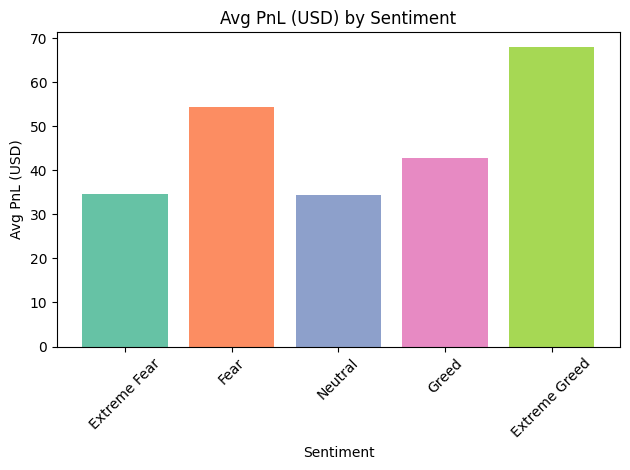

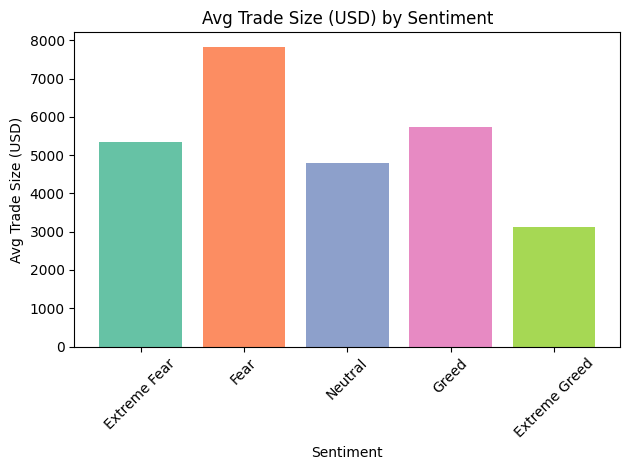

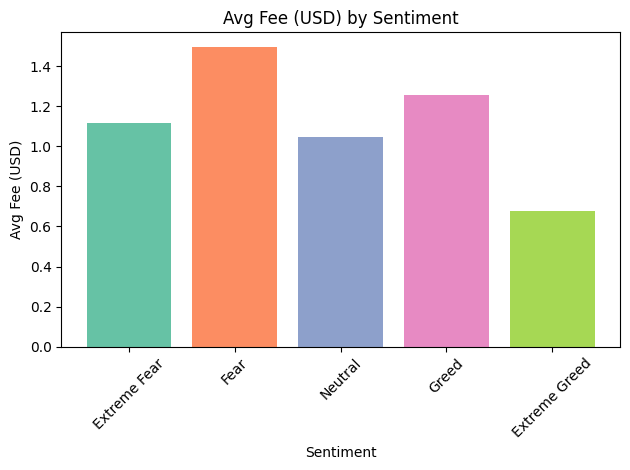

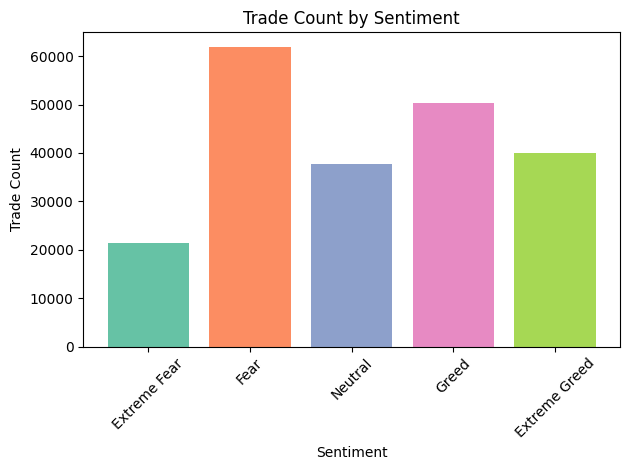

In [ ]:
import matplotlib.pyplot as plt

metrics = ['avg_pnl','avg_size_usd','avg_fee','trade_count']
titles = ['Avg PnL (USD)','Avg Trade Size (USD)','Avg Fee (USD)','Trade Count']
for m,t in zip(metrics,titles):
    fig,ax=plt.subplots()
    ax.bar(summary['classification'], summary[m], color=plt.cm.Set2.colors)
    ax.set_title(t + ' by Sentiment')
    ax.set_xlabel('Sentiment')
    ax.set_ylabel(t)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### 5.2 Time-of-Day Effects
Analyze average PnL by hour to reveal intraday patterns under different sentiments.

Interpretation tips:
- Look for consistent peaks/valleys by hour across classes.
- Cross-check with your trading hours and liquidity windows.

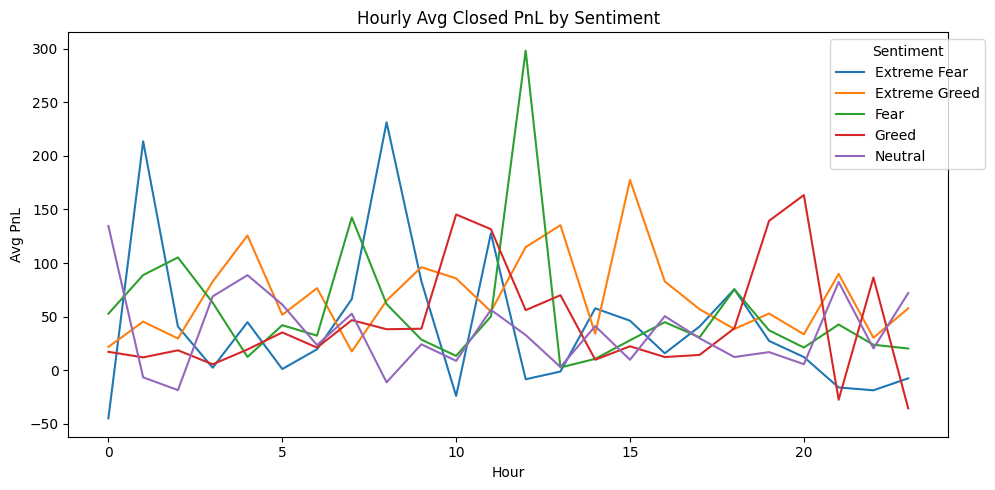

In [ ]:
hourly = data.groupby(['hour','classification'])['Closed PnL'].mean().unstack()
fig,ax=plt.subplots(figsize=(10,5))
hourly.plot(ax=ax)
ax.set_title('Hourly Avg Closed PnL by Sentiment')
ax.set_xlabel('Hour')
ax.set_ylabel('Avg PnL')
ax.legend(title='Sentiment', bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()

### 5.3 PnL Distribution Boxplots
Assess distribution shapes and outliers in PnL across sentiments. Wider boxes and longer whiskers indicate higher variability/risk.

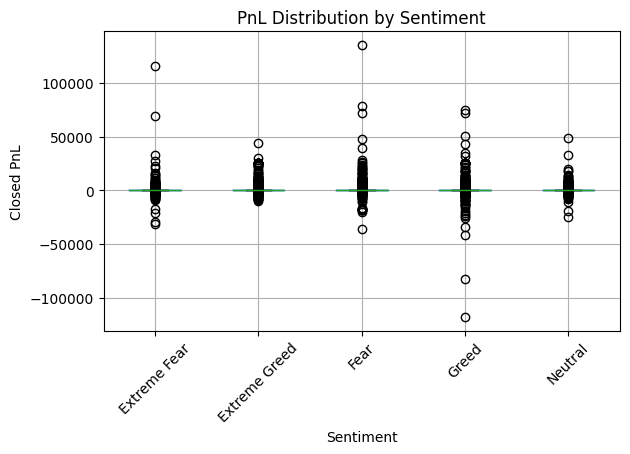

In [ ]:
fig,ax=plt.subplots()
data.boxplot(column='Closed PnL', by='classification', ax=ax)
ax.set_title('PnL Distribution by Sentiment')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Closed PnL')
plt.suptitle('')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 5.4 Top Performing Symbols
Identify which coins contribute most to total PnL. Consider filtering out illiquid symbols and normalizing by number of trades per coin.

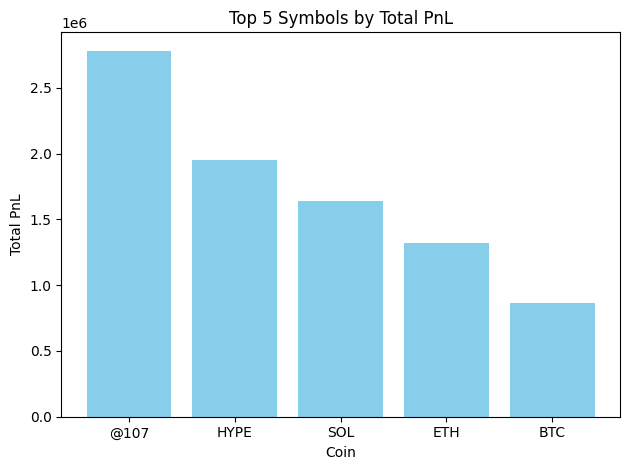

In [ ]:
top_symbols = data.groupby('Coin')['Closed PnL'].sum().nlargest(5).reset_index()
fig,ax=plt.subplots()
ax.bar(top_symbols['Coin'], top_symbols['Closed PnL'], color='skyblue')
ax.set_title('Top 5 Symbols by Total PnL')
ax.set_xlabel('Coin')
ax.set_ylabel('Total PnL')
plt.tight_layout()
plt.show()

## 6. Correlation Analysis
Evaluate linear relationships among numeric features. Correlation does not imply causation; inspect partial relationships and consider confounders (e.g., volatility, leverage).

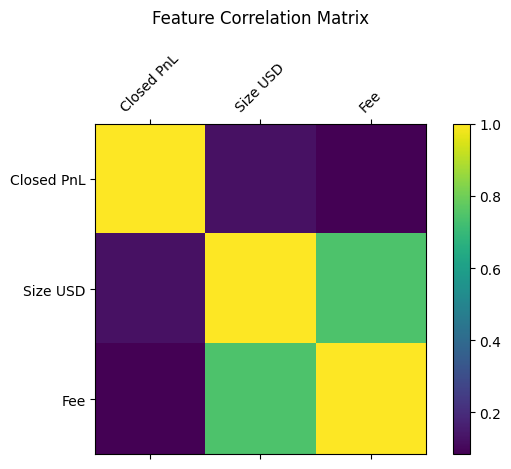

In [ ]:
corr = data[['Closed PnL','Size USD','Fee']].corr()
fig, ax = plt.subplots()
cax = ax.matshow(corr, cmap='viridis')
fig.colorbar(cax)
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45)
ax.set_yticklabels(corr.columns)
ax.set_title('Feature Correlation Matrix', pad=20)
plt.tight_layout()
plt.show()

## 7. Sentiment Trends Over Time
Visualize how sentiment prevalence evolves daily. Shifts in distribution can signal regime changes; align strategy to regime.

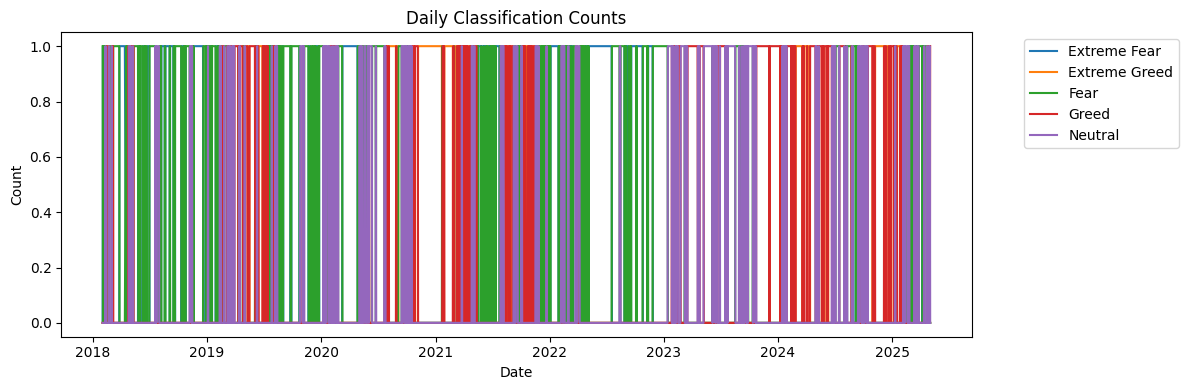

In [ ]:
time_freq = sent.groupby('date')['classification'].value_counts().unstack().fillna(0)
fig,ax=plt.subplots(figsize=(12,4))
time_freq.plot(ax=ax)
ax.set_title('Daily Classification Counts')
ax.set_xlabel('Date')
ax.set_ylabel('Count')
ax.legend(bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()

# 8. Size–PnL Relationship by Sentiment
 We visualize how trade size relates to Closed PnL across sentiment classes. Clusters or slopes can hint at risk scaling effects.

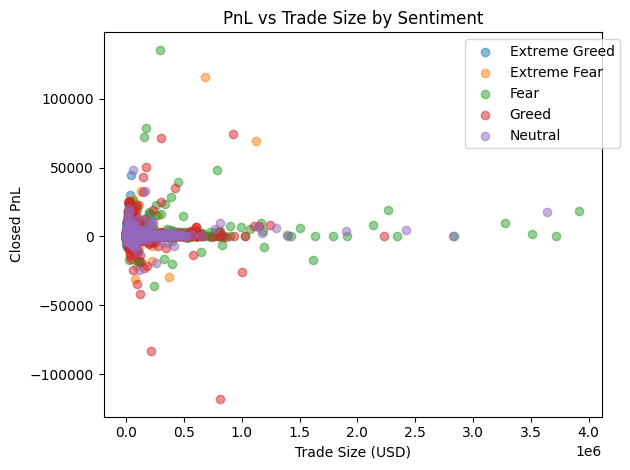


Pearson correlation (Size USD vs Closed PnL) by sentiment:
  Extreme Greed: 0.112 (n=39992)
  Extreme Fear: 0.318 (n=21400)
  Fear: 0.148 (n=61837)
  Greed: 0.037 (n=50303)
  Neutral: 0.217 (n=37686)


In [ ]:

import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for cls in data['classification'].dropna().unique():
    subset = data[data['classification']==cls]
    ax.scatter(subset['Size USD'], subset['Closed PnL'], label=cls, alpha=0.5)
ax.set_xlabel('Trade Size (USD)')
ax.set_ylabel('Closed PnL')
ax.set_title('PnL vs Trade Size by Sentiment')
ax.legend(bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()

# Per-class Pearson correlation (Size USD vs Closed PnL)
print('\nPearson correlation (Size USD vs Closed PnL) by sentiment:')
for cls in data['classification'].dropna().unique():
    subset = data.loc[data['classification']==cls, ['Size USD','Closed PnL']].dropna()
    if len(subset) >= 3:
        cor = subset['Size USD'].corr(subset['Closed PnL'])
        print(f'  {cls}: {cor:.3f} (n={len(subset)})')
    else:
        print(f'  {cls}: insufficient data (n={len(subset)})')

## 9. Actionable Insights & Strategy Recommendations
- Sentiment-driven position sizing: Reduce exposure under Extreme Fear; scale into winners under Greed with trailing stops.
- Intraday timing: Focus trading in hours where average PnL is historically favorable; avoid low-liquidity periods with negative expectancy.
- Fee optimization: Batch orders or use maker strategies during high-volume periods to cut fees.
- Asset selection: Prioritize consistently profitable symbols; rotate into top performers per sentiment regime.
- Risk controls: Tighter stops and smaller sizes on Fear days; allow wider stops when momentum is strong.

Validation next steps:
- Backtest rules by sentiment regime.
- Use walk-forward validation to avoid look-ahead bias.
- Monitor live with a small allocation before scaling.

----
This notebook provides a reproducible, end-to-end analysis merging trade data with market sentiment, complete with summaries, visuals, and practical takeaways.